In [1]:
!pip install scikit-learn xgboost lightgbm catboost

In [146]:
import sklearn
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, StackingClassifier, BaggingClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, f1_score
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier
import seaborn as sns
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
import phik
from phik.report import plot_correlation_matrix
from phik import report
import skopt
from skopt import BayesSearchCV
from joblib import dump

In [123]:
df = pd.read_excel('Subjects Components Filtered.xlsx')
df = df.drop('Subject', axis=1) # Dropping useless columns

In [124]:
df['class'] = 1

In [125]:
df.loc[df['Healthy/Eczema'] == 'Healthy', 'class'] = 0

In [126]:
df = df.drop('Healthy/Eczema', axis=1)

# Analysis of Data

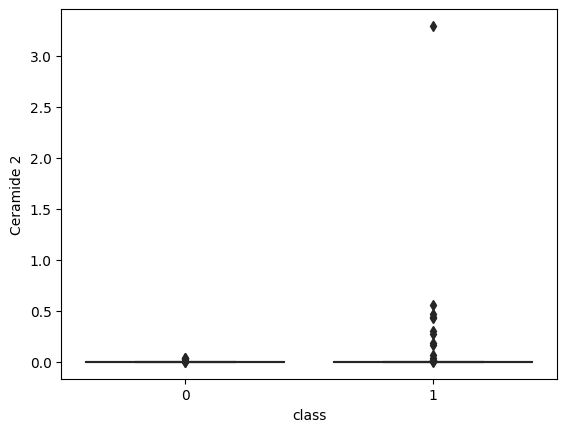

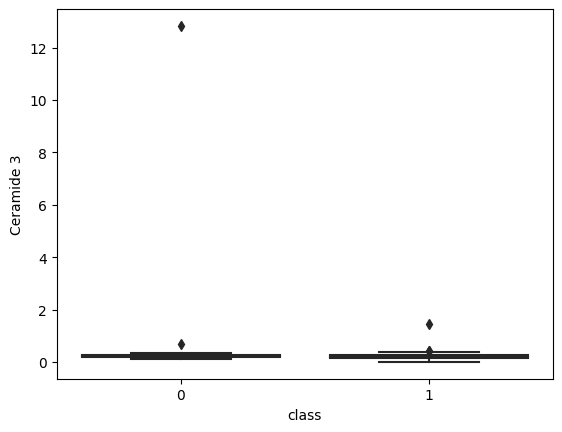

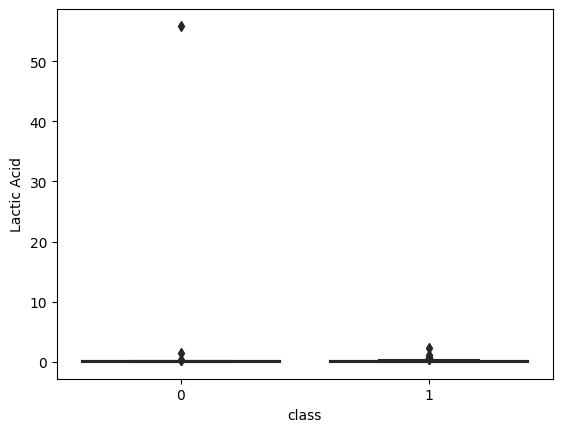

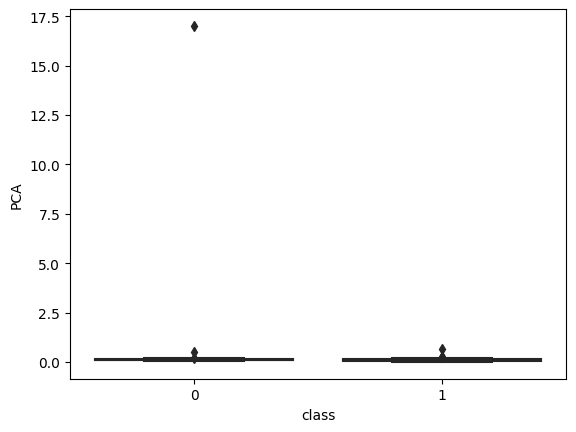

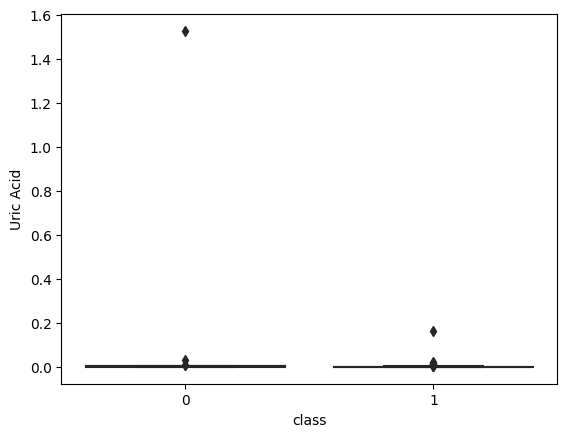

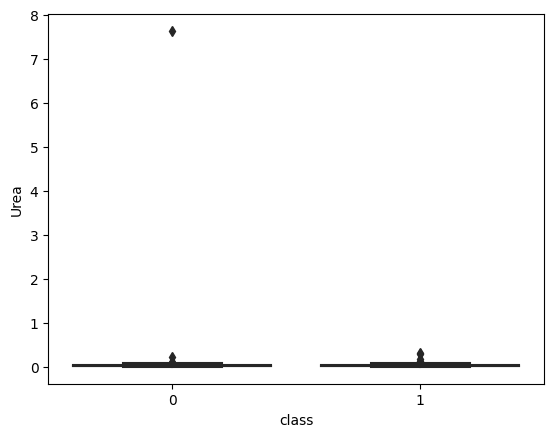

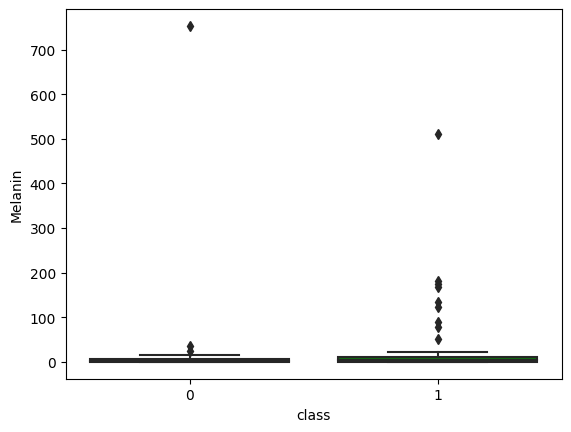

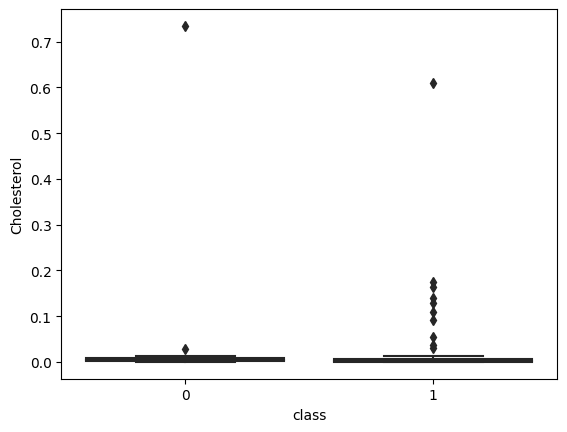

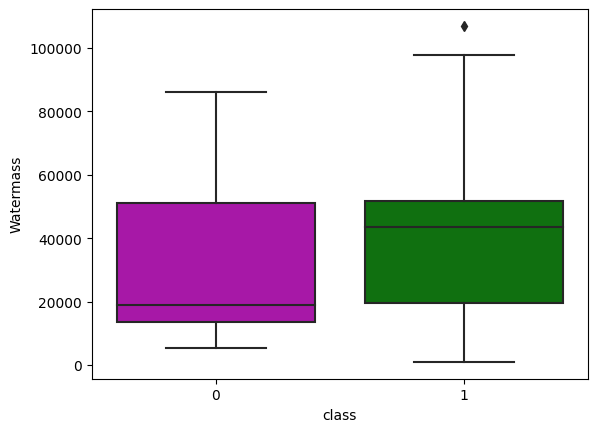

In [127]:
for i in df.columns[:-1]:
    sns.boxplot(x="class", y=i,palette=["m", "g"],data=df)
    plt.show()

We can see that there are many outliers in the data. However these outliers seem more of a limitation of the dataset than being errors in capturing data, so we will winsorise the data.

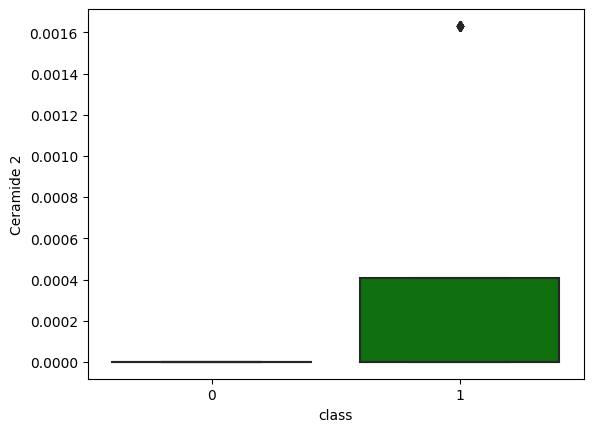

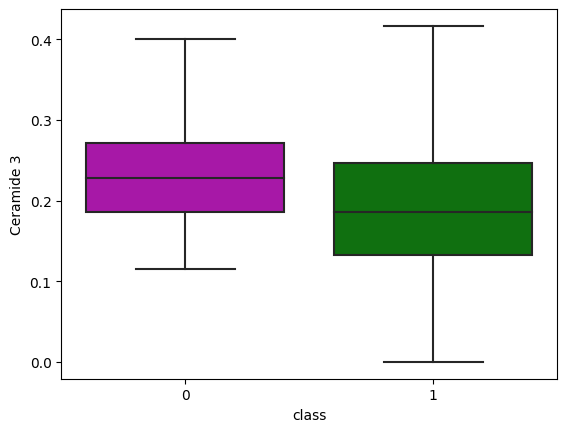

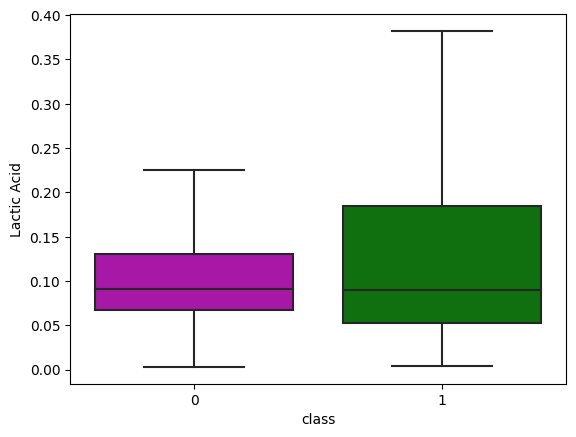

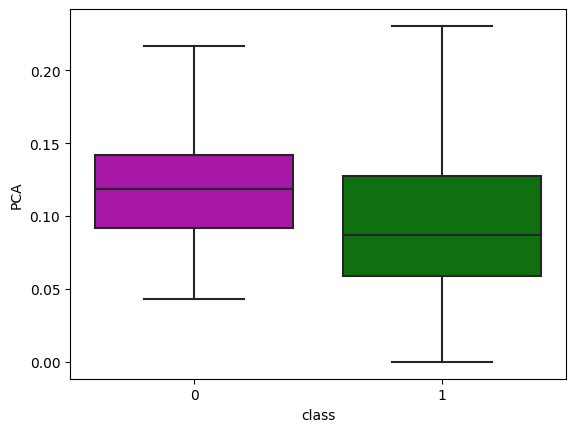

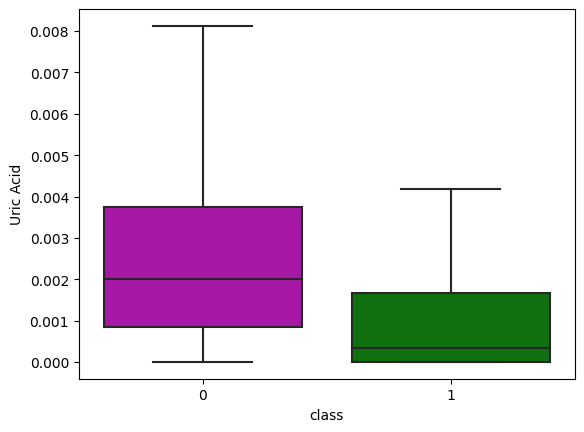

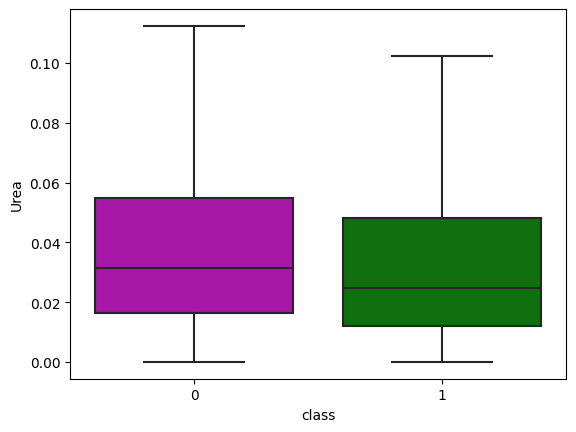

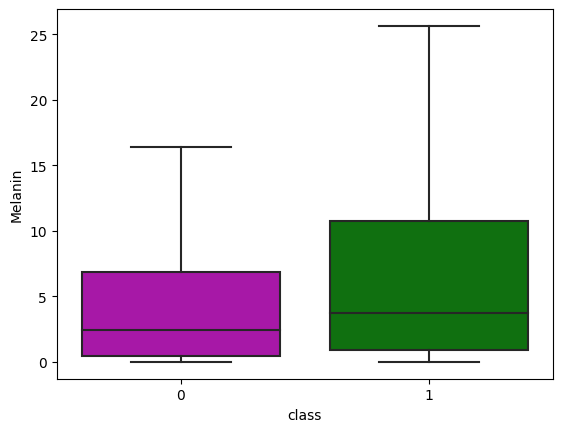

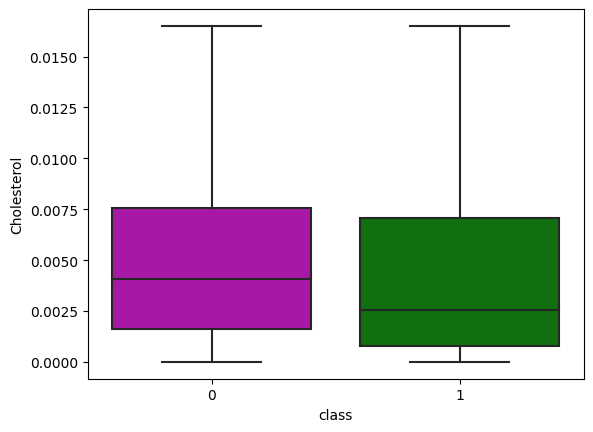

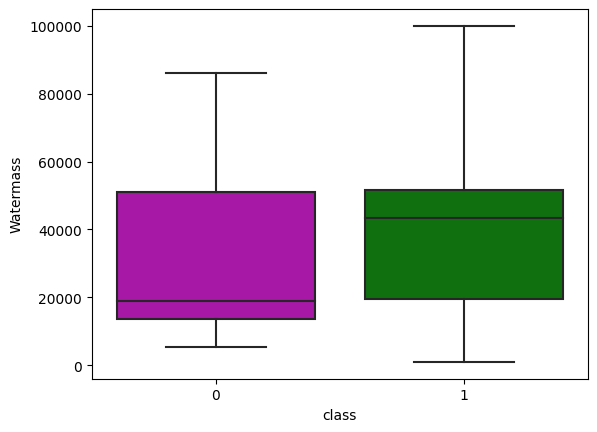

In [128]:
for col in df.columns[:-1]:
    for cls in range(2):
        percentile25 = df.loc[df['class']==cls][col].quantile(0.25)
        percentile75 = df.loc[df['class']==cls][col].quantile(0.75)
        iqr = percentile75 - percentile25
        upper_limit = percentile75 + 1.5 * iqr
        lower_limit = percentile25 - 1.5 * iqr
        df.loc[df['class']==cls, col] = np.where(
            df.loc[df['class']==cls][col] > upper_limit,
            upper_limit,
            np.where(
                df.loc[df['class']==cls][col] < lower_limit,
                lower_limit,
                df.loc[df['class']==cls][col]
            )
        )
    sns.boxplot(x="class", y=col, palette=["m", "g"],data=df)
    plt.show()

Now we will also scale the values so they are much nicer for the model to input

In [129]:
pipeline = Pipeline([
    ('scaling', ColumnTransformer([
        ('standard_scaler', StandardScaler(), df.columns[:-1])
    ])),
    ('minmax_scaler', MinMaxScaler())
])

transformed_data = pipeline.fit_transform(df)

In [130]:
df.iloc[:, :-1] = transformed_data

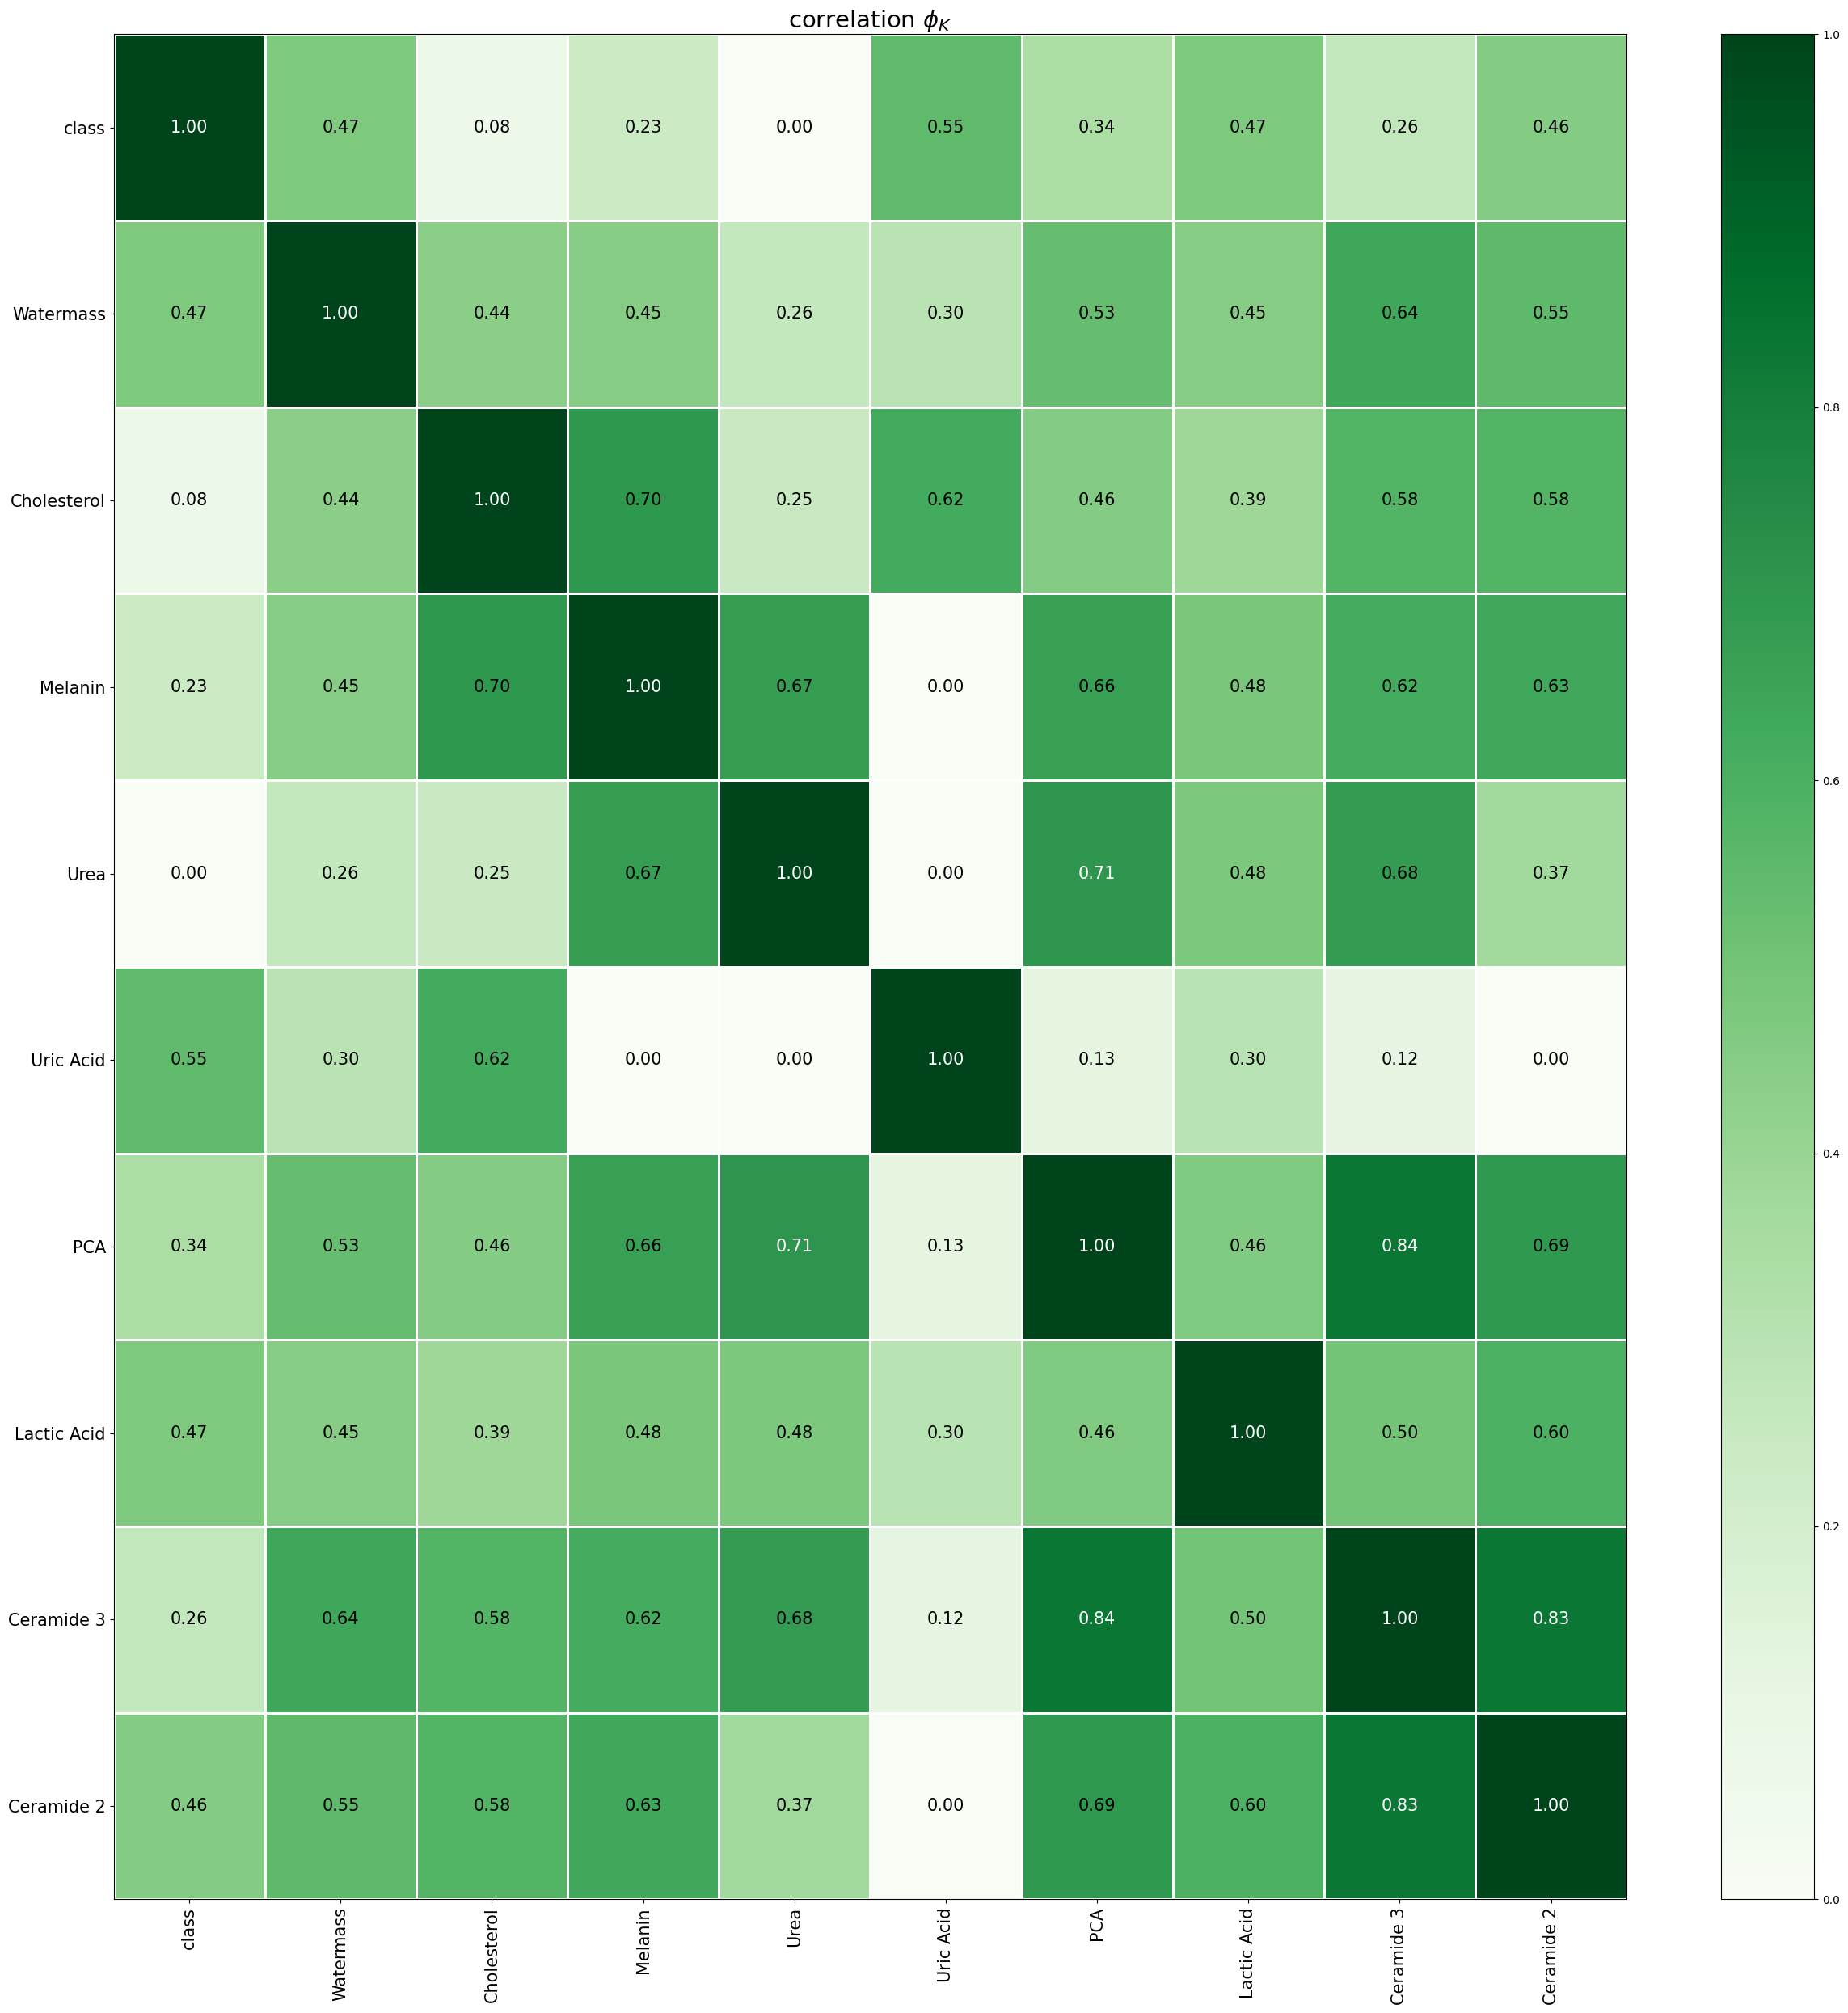

In [108]:
phik_overview = df.phik_matrix()
plot_correlation_matrix(phik_overview.values, x_labels=phik_overview.columns, y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map='Greens', title=r'correlation $\phi_K$', fontsize_factor=1.5,
                        figsize=(25,25))

interval columns not set, guessing: ['Ceramide 2', 'Ceramide 3', 'Lactic Acid', 'PCA', 'Uric Acid', 'Urea', 'Melanin', 'Cholesterol', 'Watermass', 'class']


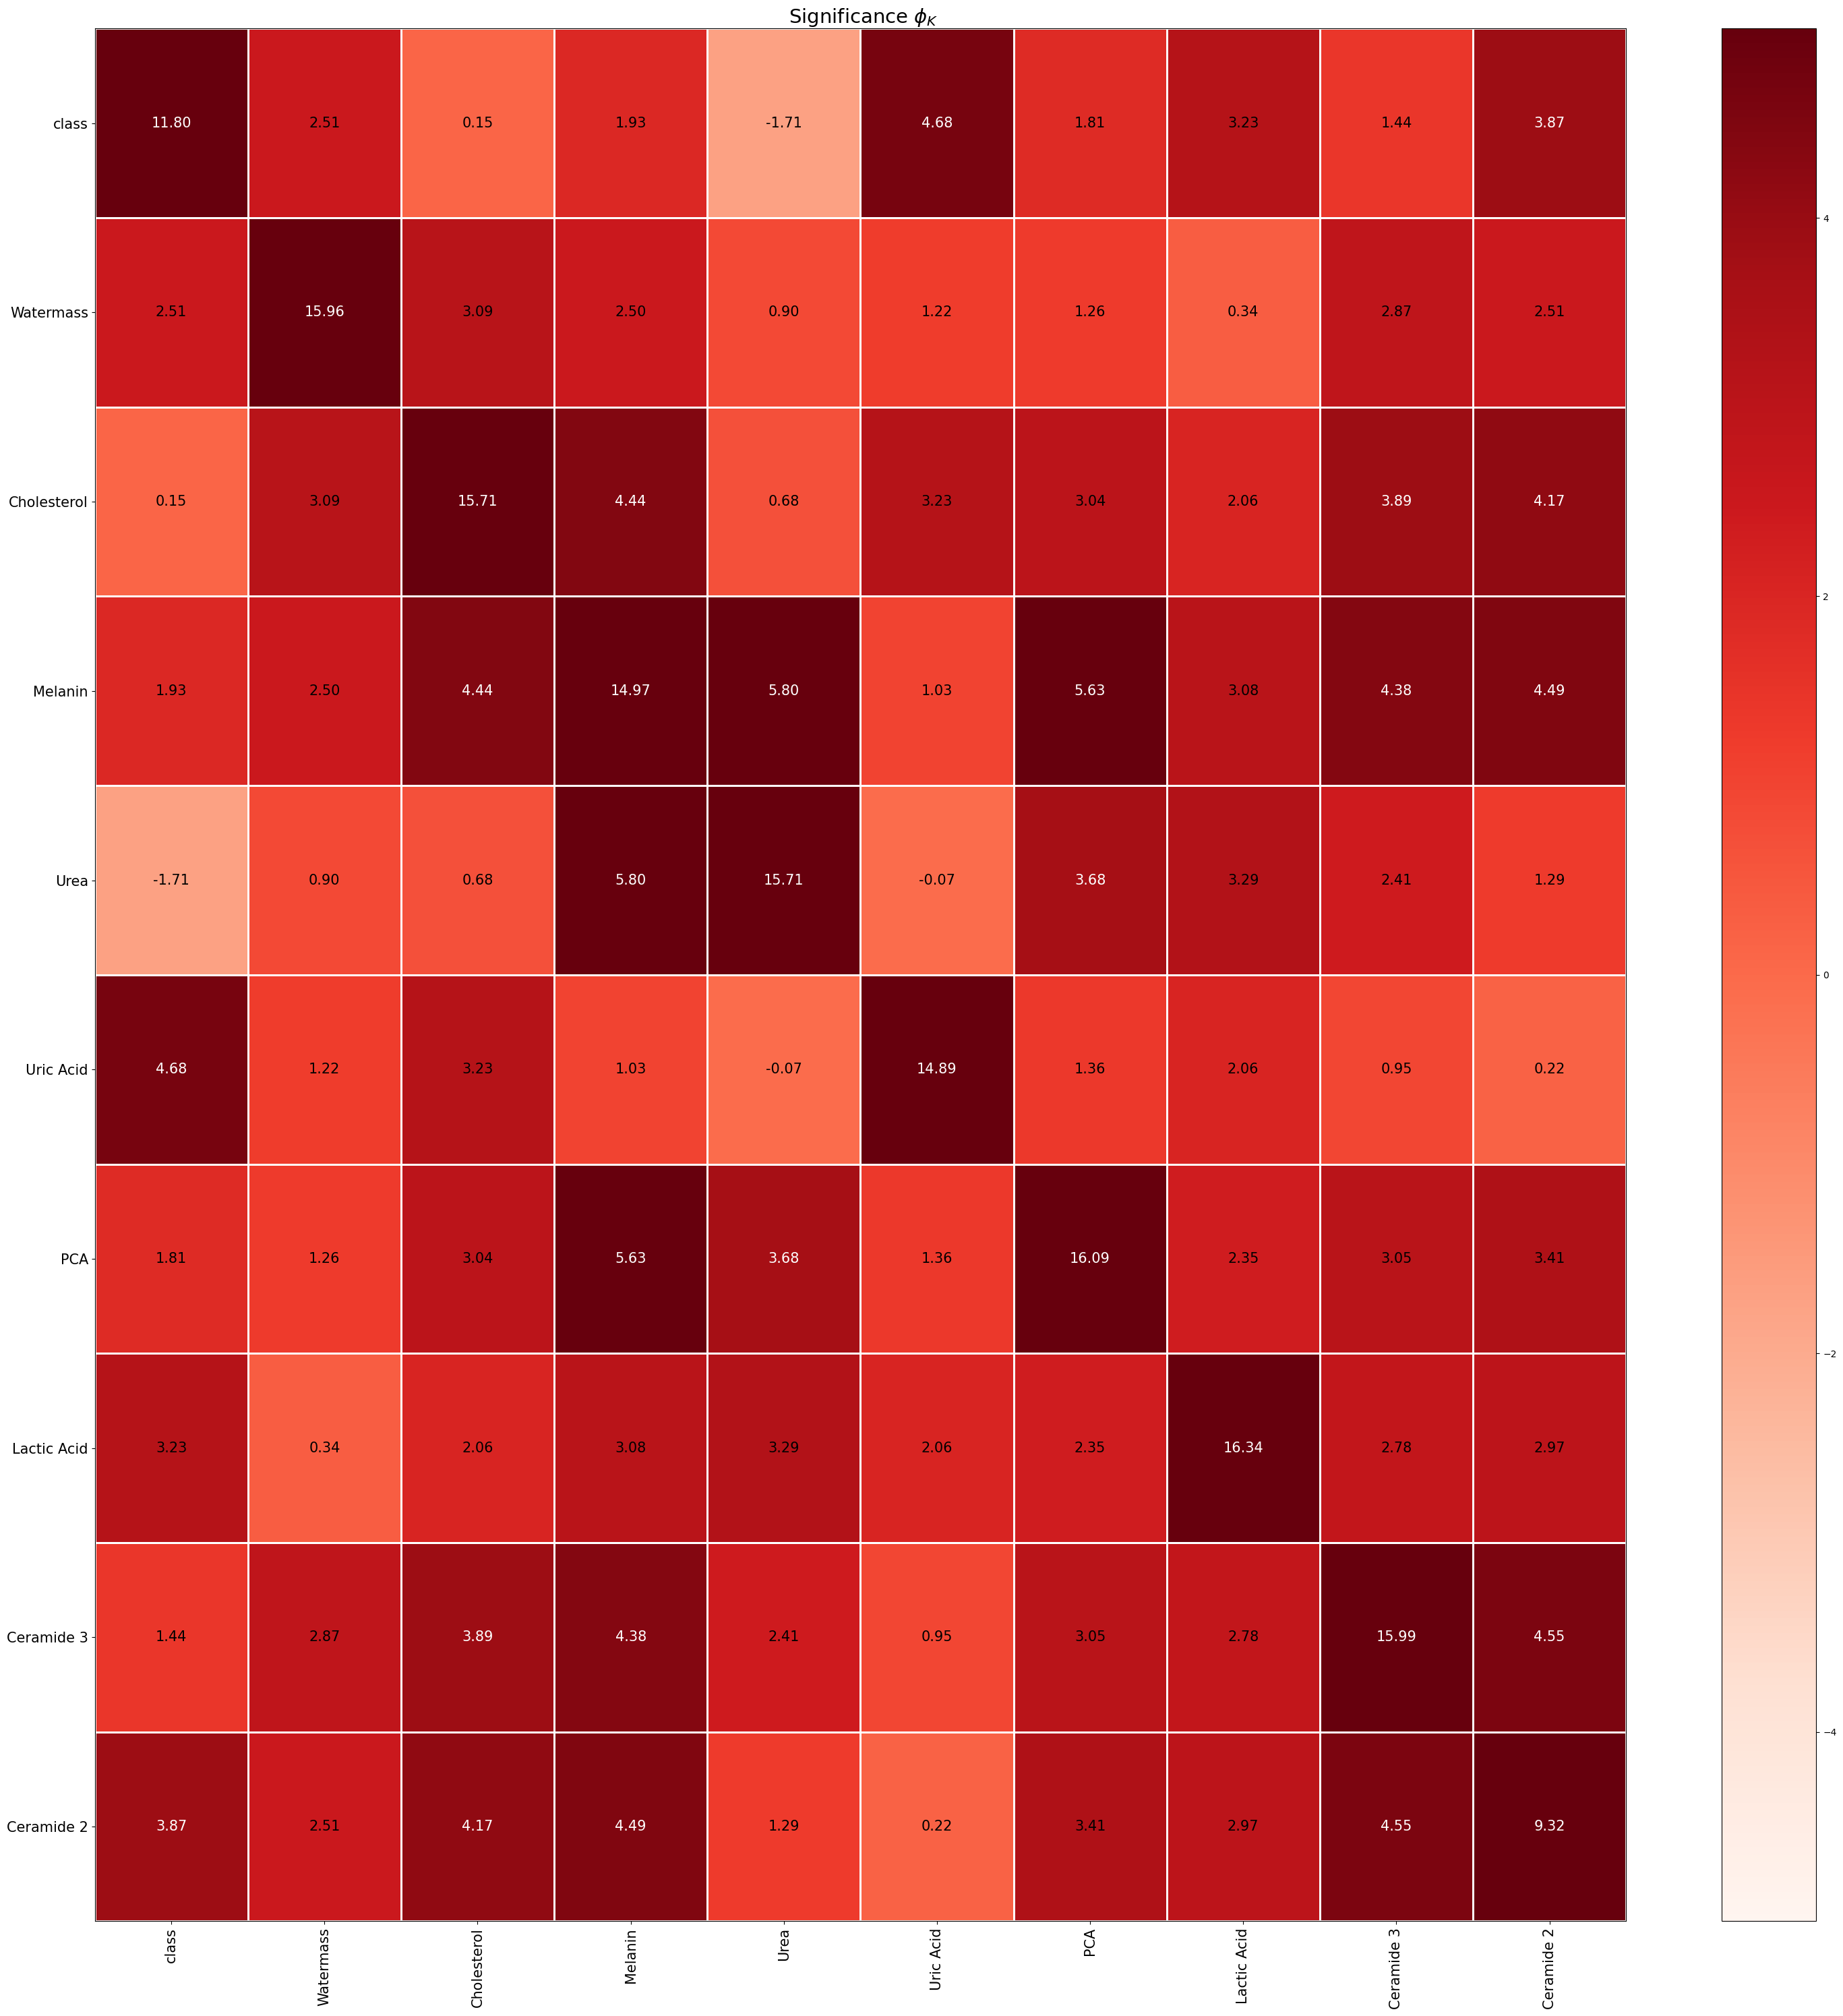

In [109]:
significancematrix = df.significance_matrix()
plot_correlation_matrix(significancematrix.values, x_labels=significancematrix.columns, y_labels=significancematrix.index, 
                        vmin=-5, vmax=5, color_map='Reds', title=r' Significance $\phi_K$', fontsize_factor=1.5,
                        figsize=(30,30))

In [135]:
df = df.drop('Cholesterol', axis=1)
df = df.drop('Urea', axis=1)

In [136]:
X = df.iloc[:, :-1]
y = df.iloc[:, -1] # Setting X and y

In [143]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y , random_state=100) # Train test split for CV

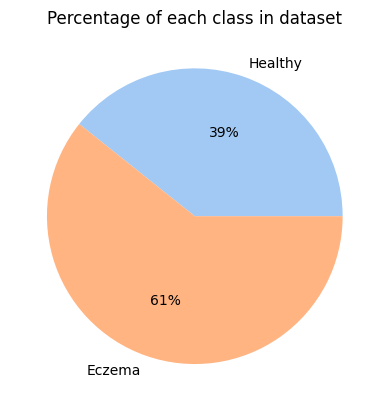

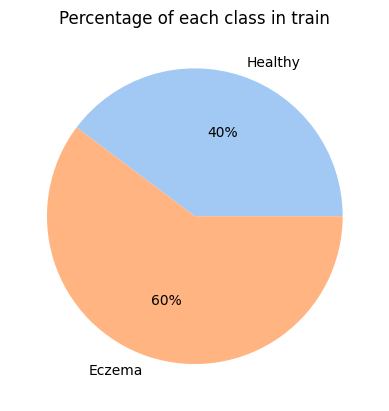

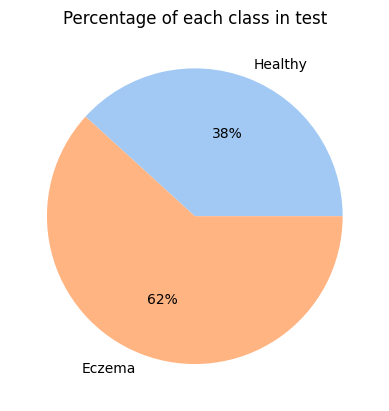

In [140]:
plt.pie([len(df[df['class']==0]), len(df[df['class']==1])], labels = ['Healthy', 'Eczema'], colors = sns.color_palette('pastel')[:2], autopct='%.0f%%')
plt.title('Percentage of each class in dataset')
plt.show()
plt.pie([len(y_train[y_train==0]), len(y_train[y_train==1])], labels = ['Healthy', 'Eczema'], colors = sns.color_palette('pastel')[:2], autopct='%.0f%%')
plt.title('Percentage of each class in train')
plt.show()
plt.pie([len(y_test[y_test==0]), len(y_test[y_test==1])], labels = ['Healthy', 'Eczema'], colors = sns.color_palette('pastel')[:2], autopct='%.0f%%')
plt.title('Percentage of each class in test')
plt.show()

We can see that the ratio of Eczema and Healthy is roughly 3 : 2 for both train and test

# Training Models

In [ ]:
models

In [141]:
classifiers = {
    'Random Forest': (RandomForestClassifier(), {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['sqrt', 'log2']
    }),
    'K-Nearest Neighbors': (KNeighborsClassifier(), {
        'n_neighbors': [3, 5, 7],
        'weights': ['uniform', 'distance'],
        'algorithm': ['auto', 'ball_tree', 'kd_tree']
    }),
    'Decision Tree': (DecisionTreeClassifier(), {
        'max_depth': [None, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['sqrt', 'log2']
    }),
    'AdaBoost': (AdaBoostClassifier(), {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.1, 0.01, 0.001]
    }),
    'XGBoost': (xgb.XGBClassifier(), {
        'n_estimators': [50, 100, 200],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.1, 0.01, 0.001],
        'subsample': [0.8, 1.0],
        'colsample_bytree': [0.8, 1.0],
    }),
    'LightGBM': (lgb.LGBMClassifier(), {
        'n_estimators': [50, 100, 200],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.1, 0.01, 0.001],
        'subsample': [0.8, 1.0],
        'colsample_bytree': [0.8, 1.0],
    }),
    'CatBoost': (CatBoostClassifier(silent=True), {
        'iterations': [50, 100, 200],
        'learning_rate': [0.1, 0.01, 0.001],
        'depth': [3, 5, 7],
    }),
}


In [144]:
for clf_name, (clf, param_bayes) in classifiers.items():
    bayes_search = BayesSearchCV(clf, param_bayes, cv=5)
    bayes_search.fit(X_train, y_train)

    best_score = bayes_search.best_score_
    best_params = bayes_search.best_params_ 

    print(f"Results for {clf_name}:")
    print("Best cross-validation accuracy:", best_score)
    print("Best hyperparameters:", best_params)
    print("-----------------------------------")
    
    best_model = bayes_search.best_estimator_
    test_score = best_model.score(X_test, y_test)
    print("Test accuracy:", test_score)
    print("-----------------------------------")
    
    y_pred = best_model.predict(X_test)
    print(sklearn.metrics.classification_report(y_test, y_pred))


C:\Users\Mahir\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Mahir\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Mahir\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Mahir\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Mahir\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Mahir\

Results for Random Forest:
Best cross-validation accuracy: 0.7967320261437909
Best hyperparameters: OrderedDict([('max_depth', 5), ('max_features', 'log2'), ('min_samples_leaf', 1), ('n_estimators', 50)])
-----------------------------------
Test accuracy: 0.782608695652174
-----------------------------------
              precision    recall  f1-score   support

           0       0.83      0.56      0.67         9
           1       0.76      0.93      0.84        14

    accuracy                           0.78        23
   macro avg       0.80      0.74      0.75        23
weighted avg       0.79      0.78      0.77        23



C:\Users\Mahir\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Mahir\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Mahir\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Mahir\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Mahir\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Mahir\

Results for K-Nearest Neighbors:
Best cross-validation accuracy: 0.7529411764705882
Best hyperparameters: OrderedDict([('algorithm', 'ball_tree'), ('n_neighbors', 7), ('weights', 'distance')])
-----------------------------------
Test accuracy: 0.6956521739130435
-----------------------------------
              precision    recall  f1-score   support

           0       0.62      0.56      0.59         9
           1       0.73      0.79      0.76        14

    accuracy                           0.70        23
   macro avg       0.68      0.67      0.67        23
weighted avg       0.69      0.70      0.69        23



C:\Users\Mahir\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Mahir\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Mahir\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Mahir\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Mahir\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Mahir\

Results for Decision Tree:
Best cross-validation accuracy: 0.765359477124183
Best hyperparameters: OrderedDict([('max_depth', 5), ('max_features', 'sqrt'), ('min_samples_leaf', 1)])
-----------------------------------
Test accuracy: 0.782608695652174
-----------------------------------
              precision    recall  f1-score   support

           0       0.75      0.67      0.71         9
           1       0.80      0.86      0.83        14

    accuracy                           0.78        23
   macro avg       0.78      0.76      0.77        23
weighted avg       0.78      0.78      0.78        23



C:\Users\Mahir\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Mahir\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Mahir\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Mahir\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Mahir\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Mahir\

Results for AdaBoost:
Best cross-validation accuracy: 0.7960784313725491
Best hyperparameters: OrderedDict([('learning_rate', 0.1), ('n_estimators', 50)])
-----------------------------------
Test accuracy: 0.782608695652174
-----------------------------------
              precision    recall  f1-score   support

           0       0.83      0.56      0.67         9
           1       0.76      0.93      0.84        14

    accuracy                           0.78        23
   macro avg       0.80      0.74      0.75        23
weighted avg       0.79      0.78      0.77        23

Results for XGBoost:
Best cross-validation accuracy: 0.7869281045751635
Best hyperparameters: OrderedDict([('colsample_bytree', 0.8), ('learning_rate', 0.01), ('max_depth', 5), ('n_estimators', 100), ('subsample', 1.0)])
-----------------------------------
Test accuracy: 0.8260869565217391
-----------------------------------
              precision    recall  f1-score   support

           0       0.86      0.

C:\Users\Mahir\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Mahir\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Mahir\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Mahir\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Mahir\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Mahir\

Results for CatBoost:
Best cross-validation accuracy: 0.8300653594771241
Best hyperparameters: OrderedDict([('depth', 3), ('iterations', 100), ('learning_rate', 0.1)])
-----------------------------------
Test accuracy: 0.8260869565217391
-----------------------------------
              precision    recall  f1-score   support

           0       0.86      0.67      0.75         9
           1       0.81      0.93      0.87        14

    accuracy                           0.83        23
   macro avg       0.83      0.80      0.81        23
weighted avg       0.83      0.83      0.82        23



In [196]:
models = []

for clf_name, (clf, param_bayes) in classifiers.items():
    bayes_search = BayesSearchCV(clf, param_bayes, cv=5)
    bayes_search.fit(X_train, y_train)

    best_score = bayes_search.best_score_
    best_params = bayes_search.best_params_ 

    print(f"Results for {clf_name}:")
    print("Best cross-validation accuracy:", best_score)
    print("Best hyperparameters:", best_params)
    print("-----------------------------------")
    
    best_model = bayes_search.best_estimator_
    test_score = best_model.score(X_test, y_test)
    print("Test accuracy:", test_score)
    print("-----------------------------------")
    
    y_pred = best_model.predict(X_test)
    print(sklearn.metrics.classification_report(y_test, y_pred))
    models.append(best_model)


C:\Users\Mahir\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Mahir\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Mahir\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Mahir\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Mahir\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Mahir\

Results for Random Forest:
Best cross-validation accuracy: 0.7973856209150327
Best hyperparameters: OrderedDict([('max_depth', 10), ('max_features', 'log2'), ('min_samples_leaf', 1), ('n_estimators', 50)])
-----------------------------------
Test accuracy: 0.8695652173913043
-----------------------------------
              precision    recall  f1-score   support

           0       0.88      0.78      0.82         9
           1       0.87      0.93      0.90        14

    accuracy                           0.87        23
   macro avg       0.87      0.85      0.86        23
weighted avg       0.87      0.87      0.87        23



C:\Users\Mahir\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Mahir\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Mahir\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Mahir\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Mahir\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Mahir\

Results for K-Nearest Neighbors:
Best cross-validation accuracy: 0.7529411764705882
Best hyperparameters: OrderedDict([('algorithm', 'auto'), ('n_neighbors', 7), ('weights', 'distance')])
-----------------------------------
Test accuracy: 0.6956521739130435
-----------------------------------
              precision    recall  f1-score   support

           0       0.62      0.56      0.59         9
           1       0.73      0.79      0.76        14

    accuracy                           0.70        23
   macro avg       0.68      0.67      0.67        23
weighted avg       0.69      0.70      0.69        23



C:\Users\Mahir\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Mahir\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Mahir\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Mahir\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Mahir\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Mahir\

Results for Decision Tree:
Best cross-validation accuracy: 0.8320261437908496
Best hyperparameters: OrderedDict([('max_depth', 10), ('max_features', 'sqrt'), ('min_samples_leaf', 4)])
-----------------------------------
Test accuracy: 0.7391304347826086
-----------------------------------
              precision    recall  f1-score   support

           0       0.80      0.44      0.57         9
           1       0.72      0.93      0.81        14

    accuracy                           0.74        23
   macro avg       0.76      0.69      0.69        23
weighted avg       0.75      0.74      0.72        23



C:\Users\Mahir\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Mahir\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Mahir\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Mahir\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Mahir\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Mahir\

Results for AdaBoost:
Best cross-validation accuracy: 0.7960784313725491
Best hyperparameters: OrderedDict([('learning_rate', 0.1), ('n_estimators', 50)])
-----------------------------------
Test accuracy: 0.782608695652174
-----------------------------------
              precision    recall  f1-score   support

           0       0.83      0.56      0.67         9
           1       0.76      0.93      0.84        14

    accuracy                           0.78        23
   macro avg       0.80      0.74      0.75        23
weighted avg       0.79      0.78      0.77        23

Results for XGBoost:
Best cross-validation accuracy: 0.7869281045751635
Best hyperparameters: OrderedDict([('colsample_bytree', 0.8), ('learning_rate', 0.01), ('max_depth', 5), ('n_estimators', 100), ('subsample', 1.0)])
-----------------------------------
Test accuracy: 0.8260869565217391
-----------------------------------
              precision    recall  f1-score   support

           0       0.86      0.

C:\Users\Mahir\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Mahir\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Mahir\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Mahir\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Mahir\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Mahir\

Results for CatBoost:
Best cross-validation accuracy: 0.8300653594771241
Best hyperparameters: OrderedDict([('depth', 3), ('iterations', 100), ('learning_rate', 0.1)])
-----------------------------------
Test accuracy: 0.8260869565217391
-----------------------------------
              precision    recall  f1-score   support

           0       0.86      0.67      0.75         9
           1       0.81      0.93      0.87        14

    accuracy                           0.83        23
   macro avg       0.83      0.80      0.81        23
weighted avg       0.83      0.83      0.82        23



In [185]:
from sklearn.model_selection import StratifiedKFold

estimators = [(name, clf) for name, (clf, _) in classifiers.items()]
stacking_clf = StackingClassifier(estimators=estimators, final_estimator=xgb.XGBClassifier())
stacking_clf.fit(X_train, y_train)

StackingClassifier(estimators=[('Random Forest', RandomForestClassifier()),
                               ('K-Nearest Neighbors', KNeighborsClassifier()),
                               ('Decision Tree', DecisionTreeClassifier()),
                               ('AdaBoost', AdaBoostClassifier()),
                               ('XGBoost',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              early_stopping_roun...
                                                 gpu_id=None, grow_policy=None,
                                                 importance_type=None,
                                                 interaction_constraints=None,
                                                 learning_rate=None,
                                                 max_bin=None,
                                                 max_cat_threshold=None,
                                                 max_cat_to_onehot=None,
                                                 max_delta_step=None,
                                                 max_depth=None,
                                                 max_leaves=None,
                                                 min_child_weight=None,
                                                 missing=nan,
                                                 monotone_constraints=None,
                                                 n_estimators=100, n_jobs=None,
                                                 num_parallel_tree=None,
                                                 predictor=None,
                                                 random_state=None, ...))

In [186]:
bagging_clf = BaggingClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=100)
bagging_clf.fit(X_train, y_train)

C:\Users\Mahir\anaconda3\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


BaggingClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=100)

In [187]:
y_pred = bagging_clf.predict(X_test)
print(sklearn.metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.67      0.75         9
           1       0.81      0.93      0.87        14

    accuracy                           0.83        23
   macro avg       0.83      0.80      0.81        23
weighted avg       0.83      0.83      0.82        23



In [188]:
y_pred = stacking_clf.predict(X_test)
print(sklearn.metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.64      0.78      0.70         9
           1       0.83      0.71      0.77        14

    accuracy                           0.74        23
   macro avg       0.73      0.75      0.73        23
weighted avg       0.76      0.74      0.74        23



In [197]:
models

[RandomForestClassifier(max_depth=10, max_features='log2', n_estimators=50),
 KNeighborsClassifier(n_neighbors=7, weights='distance'),
 DecisionTreeClassifier(max_depth=10, max_features='sqrt', min_samples_leaf=4),
 AdaBoostClassifier(learning_rate=0.1),
 XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=0.8, early_stopping_rounds=None,
               enable_categorical=False, eval_metric=None, feature_types=None,
               gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
               interaction_constraints=None, learning_rate=0.01, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=5, max_leaves=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               n_estimators=100, n_jobs=None, num_parallel_tree=None,
               predictor=None, random_sta

In [198]:
del models[1]
sm = np.zeros(7)
for model in models:
    importances = model.feature_importances_
    sm += np.array(importances)

In [199]:
base_estimator_importances = np.zeros(7)  
for estimator in stacking_clf.estimators:
    if hasattr(estimator, 'feature_importances_'):
        base_estimator_importances += estimator.feature_importances_
base_estimator_importances = base_estimator_importances/len(models)

In [200]:
feature_importances = np.mean([
    tree.feature_importances_ for tree in bagging_clf.estimators_
], axis=0)

In [201]:
len(models)

6

In [202]:
feature_importances = (base_estimator_importances + sm + feature_importances) / 8

<Axes: title={'center': 'Average Feature Importance of all classifiers'}, xlabel='Features', ylabel='Feature Importance'>

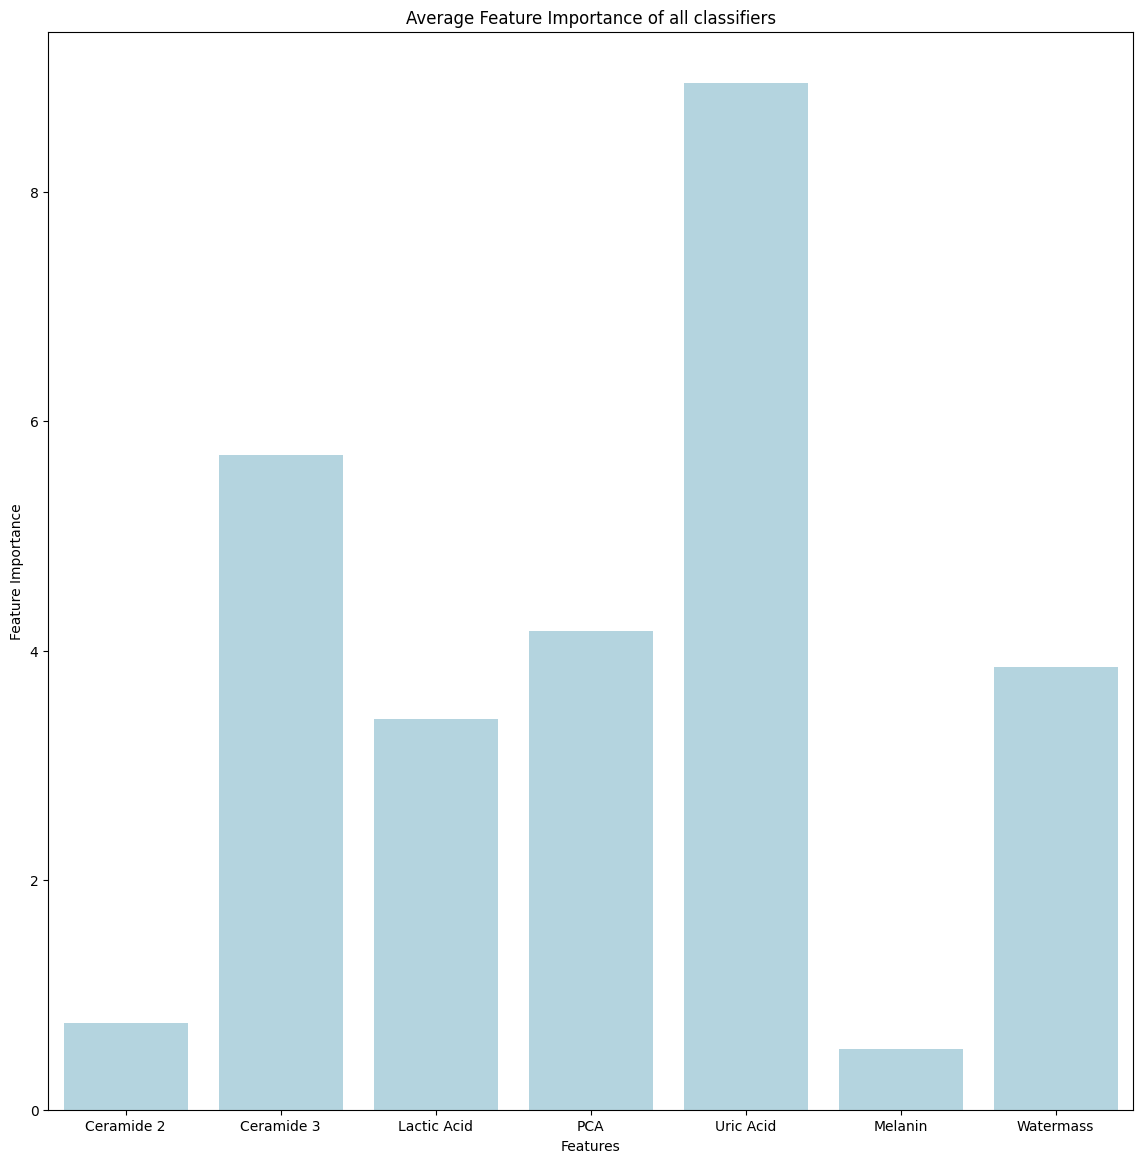

In [204]:
import matplotlib.pyplot

plt.figure(figsize=(14, 14))
plt.xlabel('Features')
plt.ylabel('Feature Importance')
plt.title('Average Feature Importance of all classifiers')
sns.barplot(y=feature_importances, x=X.columns, color='b', palette=['lightblue'])